In [6]:
import torch
import numpy as np

torch.manual_seed(0)

In [7]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns u(x,y), computes d^2u/dx^2 using torch.autograd."""
    grad= torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(outputs),
        create_graph = True,
        retain_graph = True,
        )[0]

    grad_y = grad[:, 1]  # Select the column corresponding to the derivative with respect to y
    second_derivative_y = torch.autograd.grad(
        grad_y,
        inputs,
        torch.ones_like(grad_y),  # This tensor is required as grad_y is not scalar
        create_graph=True,
        retain_graph=True
        )[0]


    grad_x = grad[:, 0]  # Select the column corresponding to the derivative with respect to y
    second_derivative_x = torch.autograd.grad(
        grad_x,
        inputs,
        torch.ones_like(grad_y),  # This tensor is required as grad_y is not scalar
        create_graph=True,
        retain_graph=True
        )[0]
    sec2=torch.add(second_derivative_x[:,0],second_derivative_y[:,1])

    return sec2



In [8]:
# Mean-squared error as the comparison criterion
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    model_output = torch.sqrt(torch.real(model(inputs)))
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = torch.zeros_like(model_output[:,0])
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 0
    boundary_left = inputs.detach().clone()
    boundary_left[:,0] = 0
    boundary_bottom = inputs.detach().clone()
    boundary_bottom[:,1] = 0
    boundary_right = inputs.detach().clone()
    boundary_right[:,0] = 1
    boundary_top = inputs.detach().clone()
    boundary_top[:,1] = 1

    boundary1_model = model(boundary_left)
    boundary1_exact = torch.sin(torch.pi * inputs[:,1]).unsqueeze(1)
    boundary1_loss = criterion(boundary1_model, boundary1_exact)
    boundary2_model = model(boundary_bottom)
    boundary2_exact = torch.zeros_like(model_output)
    boundary2_loss = criterion(boundary2_model, boundary2_exact)
    boundary3_model = model(boundary_right)
    boundary3_exact = np.exp(-torch.pi)*torch.sin(torch.pi * inputs[:,1]).unsqueeze(1)
    boundary3_loss = criterion(boundary3_model, boundary3_exact)
    boundary4_model = model(boundary_top)
    boundary4_exact = torch.zeros_like(model_output)
    boundary4_loss = criterion(boundary4_model, boundary4_exact)

    return 0.01*ode_loss + boundary1_loss + boundary2_loss + boundary3_loss + boundary4_loss

In [9]:
from qadence import feature_map, hea, chain, add, kron, identity_initialized_ansatz
from qadence import QNN, QuantumCircuit, Z, HamEvo, I, FeatureParameter, Projector, block_to_tensor
from qadence.types import BasisSet, ReuploadScaling

n_qubits = 4
depth = 6



# Ansatz
ansatz_first_half = hea(n_qubits=int(n_qubits/2), depth=8, support=(0,1))
ansatz_second_half = hea(n_qubits=int(n_qubits/2), depth=8, support=(2,3))
ansatz_complete = hea(n_qubits=n_qubits, depth=8, support=(0,1,2,3))
ham = add(2**j * Z(j) for j in range(n_qubits)) + 2**n_qubits*kron(I(j) for j in range(n_qubits))
x, y = FeatureParameter("x"), FeatureParameter("y")
z = -1.0j * x - y
ham_evo = HamEvo(torch.pi*ham, z)

# Observable
project = Projector(ket="0000", bra="0000", qubit_support=(0,1,2,3))

observable = Z(3)

circuit = QuantumCircuit(n_qubits, chain(ansatz_first_half, ansatz_second_half, ham_evo, ansatz_complete, project))
model = QNN(circuit = circuit, observable = observable, inputs = ["x", "y"])

In [10]:
n_epochs = 1000

xmin = 0
xmax = 0.999
x_points = 10
ymin = 0
ymax = 0.999
y_points = 10

optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Training data. We unsqueeze essentially making each batch have a single x value.
    xy_train = torch.stack((xmin + (xmax-xmin)*torch.rand(x_points, y_points, requires_grad = True),
           ymin + (ymax-ymin)*torch.rand(x_points, y_points, requires_grad = True))).swapdims(0, 2).flatten(end_dim=1)

    loss = loss_fn(inputs = xy_train, model = model)
    print(loss)
    loss.backward()
    optimizer.step()

tensor(1.7219, grad_fn=<AddBackward0>)
tensor(48.9322, grad_fn=<AddBackward0>)
tensor(3.5526, grad_fn=<AddBackward0>)
tensor(0.7326, grad_fn=<AddBackward0>)
tensor(7.5599, grad_fn=<AddBackward0>)
tensor(0.3496, grad_fn=<AddBackward0>)
tensor(0.9472, grad_fn=<AddBackward0>)
tensor(0.3301, grad_fn=<AddBackward0>)
tensor(0.4547, grad_fn=<AddBackward0>)
tensor(0.5045, grad_fn=<AddBackward0>)
tensor(0.6172, grad_fn=<AddBackward0>)
tensor(5.7974, grad_fn=<AddBackward0>)
tensor(1.9685, grad_fn=<AddBackward0>)
tensor(1.3925, grad_fn=<AddBackward0>)
tensor(1.5249, grad_fn=<AddBackward0>)
tensor(0.4791, grad_fn=<AddBackward0>)
tensor(0.4468, grad_fn=<AddBackward0>)
tensor(0.3826, grad_fn=<AddBackward0>)
tensor(0.8458, grad_fn=<AddBackward0>)
tensor(0.9137, grad_fn=<AddBackward0>)
tensor(1.2151, grad_fn=<AddBackward0>)
tensor(10.9603, grad_fn=<AddBackward0>)
tensor(2.0093, grad_fn=<AddBackward0>)
tensor(0.5704, grad_fn=<AddBackward0>)
tensor(0.5153, grad_fn=<AddBackward0>)
tensor(0.4930, grad_fn=

C:\Users\Gabriele\anaconda3\envs\qadence\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


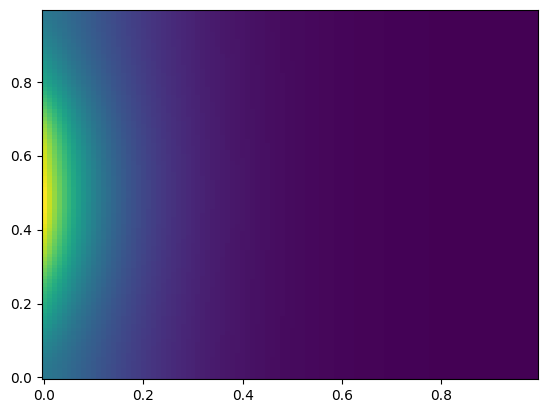

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# result_exact = f_exact(x_test).flatten()
x = torch.arange(xmin, xmax, 0.01)
xy_test = torch.cartesian_prod(x, x)

X, Y = torch.meshgrid(x, x)

result_model = model(xy_test).detach().unflatten(0,(x.shape[0], x.shape[0]))

# plt.plot(x_test, result_exact, label = "Exact solution")
plt.pcolormesh(X.detach().numpy(), Y.detach().numpy(), result_model.squeeze(2).detach().numpy(), label = " Trained model")

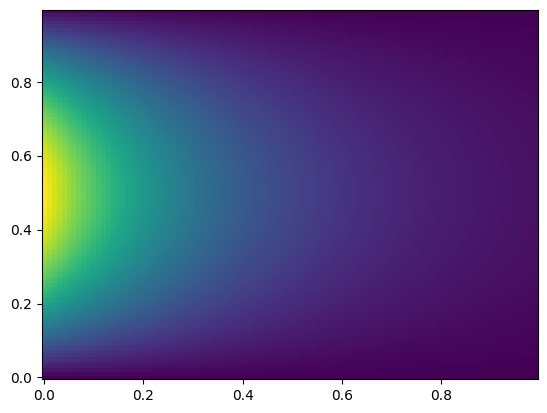

In [12]:
# result_exact = f_exact(x_test).flatten()
x = torch.arange(xmin, xmax, 0.01)
xy_test = torch.cartesian_prod(x, x)

X, Y = torch.meshgrid(x, x)

result_model = torch.exp(-torch.pi*X)*torch.sin(torch.pi*Y)

# plt.plot(x_test, result_exact, label = "Exact solution")
plt.pcolormesh(X.detach().numpy(), Y.detach().numpy(), result_model.detach().numpy(), label = " Trained model")